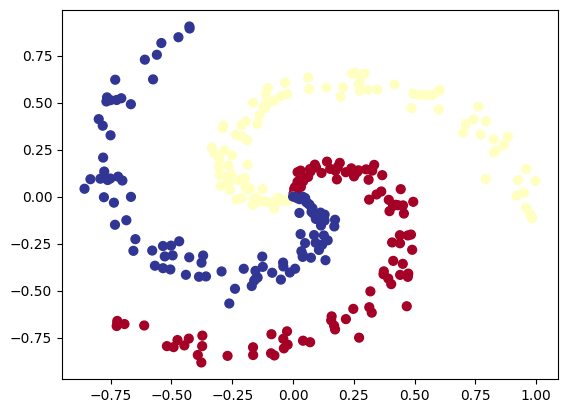

In [345]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [346]:
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from pathlib import Path
from requests import get

In [347]:
if not Path("helper_functions.py").is_file():
  req = get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py" , "wb") as f:
    f.write(req.content)
    f.close()
import helper_functions as hf

In [348]:
epoch_count = [0]
loss_vals , test_loss_vals , acc_vals , test_acc_vals = [] , [] , [] , []

In [349]:
X_train , X_test  , y_train , y_test = train_test_split(torch.tensor(X).type(torch.float)  , torch.tensor(y).type(torch.LongTensor) , test_size = 0.2 , shuffle = True , random_state = 1234)

In [350]:
class Spiral(nn.Module):
  def __init__(self):
    super().__init__()
    self.seq=nn.Sequential(
        nn.Hardswish(),
        nn.Linear(in_features = 2 , out_features = 8),
        nn.Hardswish(),
        nn.Linear(in_features = 8, out_features = 4)
    )

  def forward(self , X):
    return self.seq(X);


In [351]:
model = Spiral()

In [352]:

loss_fn = nn.CrossEntropyLoss()
lr = 0.1
optimizer = torch.optim.Adam(params = model.parameters() , lr = lr)

In [353]:
# changing device
def change_device(device = None , model = model , X_train = X_train ,X_test=X_test  , y_train = y_train , y_test = y_test ):
  if not device : device = "cuda" if torch.cuda.is_available() else "cpu"
  og_things = [model , X_train , X_test  , y_train , y_test]
  things = [i.to(device) for i in og_things]
  # for i in og_things:
  #   print(i)
  return

In [354]:
change_device()

In [355]:
def logit_acc(logits:torch.tensor , target:torch.tensor) -> int:
  sf = nn.Softmax()
  return torch.sum(torch.argmax(torch.softmax(logits , dim= 1),dim=1) == target)*100 / len(target)

In [356]:
best_model_state=[0,None]

In [357]:
for epoch in range(1+ 300):
  model.train()
  y_logits = model(X_train)
  loss = loss_fn(y_logits , y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if epoch % 10 == 0 :
    model.eval()
    y_test_logits = model(X_test)
    test_loss = loss_fn(y_test_logits , y_test)

    acc = logit_acc(y_logits , y_train)
    test_acc = logit_acc(y_test_logits , y_test)

    epoch_count.append(epoch)
    loss_vals.append(loss)
    test_loss_vals.append(test_loss)
    acc_vals.append(acc)
    test_acc_vals.append(test_acc)

    print(f"epoch : {epoch} | loss : {loss:.2f} , test loss : {test_loss:.2f} | acc : {acc:.2f} , test acc : {test_acc:.2f}")
    avg_acc =((acc+test_acc) /2)
    best_model_state = [avg_acc , model.state_dict()] if best_model_state[0] < avg_acc else best_model_state



epoch : 0 | loss : 1.31 , test loss : 1.22 | acc : 34.17 , test acc : 41.67
epoch : 10 | loss : 0.79 , test loss : 0.85 | acc : 54.58 , test acc : 51.67
epoch : 20 | loss : 0.74 , test loss : 0.84 | acc : 52.50 , test acc : 46.67
epoch : 30 | loss : 0.68 , test loss : 0.79 | acc : 60.83 , test acc : 50.00
epoch : 40 | loss : 0.60 , test loss : 0.70 | acc : 70.83 , test acc : 63.33
epoch : 50 | loss : 0.52 , test loss : 0.61 | acc : 71.25 , test acc : 68.33
epoch : 60 | loss : 0.42 , test loss : 0.48 | acc : 81.25 , test acc : 81.67
epoch : 70 | loss : 0.30 , test loss : 0.34 | acc : 88.75 , test acc : 90.00
epoch : 80 | loss : 0.21 , test loss : 0.24 | acc : 94.17 , test acc : 93.33
epoch : 90 | loss : 0.16 , test loss : 0.18 | acc : 95.00 , test acc : 93.33
epoch : 100 | loss : 0.12 , test loss : 0.14 | acc : 96.67 , test acc : 96.67
epoch : 110 | loss : 0.10 , test loss : 0.11 | acc : 98.33 , test acc : 96.67
epoch : 120 | loss : 0.08 , test loss : 0.10 | acc : 97.50 , test acc : 96.

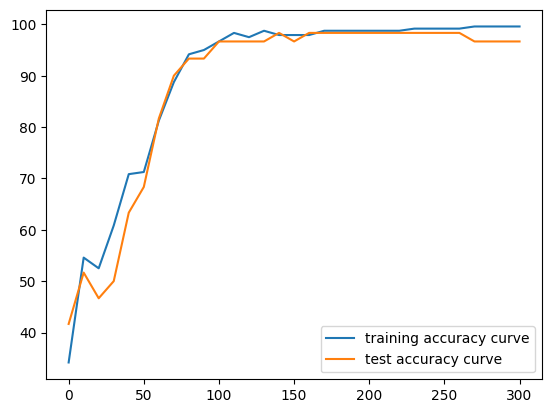

In [365]:
plt.plot(epoch_count[1:] , torch.tensor(acc_vals) , label = "training accuracy curve")
plt.plot(epoch_count[1:] , torch.tensor(test_acc_vals) , label = "test accuracy curve")
plt.legend()

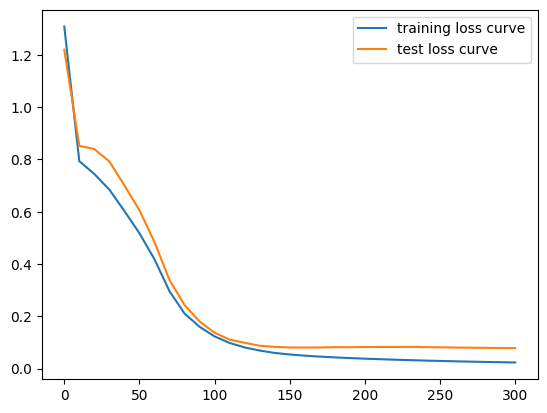

In [366]:
plt.plot(epoch_count[1:] , torch.tensor(loss_vals) , label = "training loss curve")
plt.plot(epoch_count[1:] , torch.tensor(test_loss_vals) , label = "test loss curve")
plt.legend()

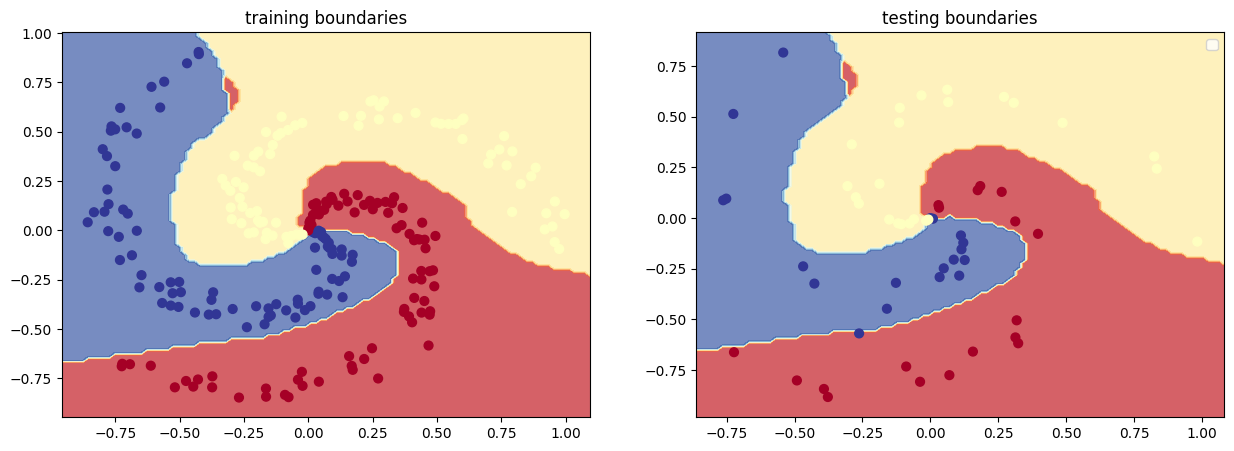

In [360]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
hf.plot_decision_boundary(model,X_train,y_train)
plt.title("training boundaries")
plt.subplot(1,2,2)
hf.plot_decision_boundary(model,X_test,y_test)
plt.title("testing boundaries")
plt.legend()

In [361]:
best_model = Spiral()
best_model.load_state_dict(best_model_state[1])

<All keys matched successfully>

In [362]:
best_model_state[0]

tensor(98.7500)

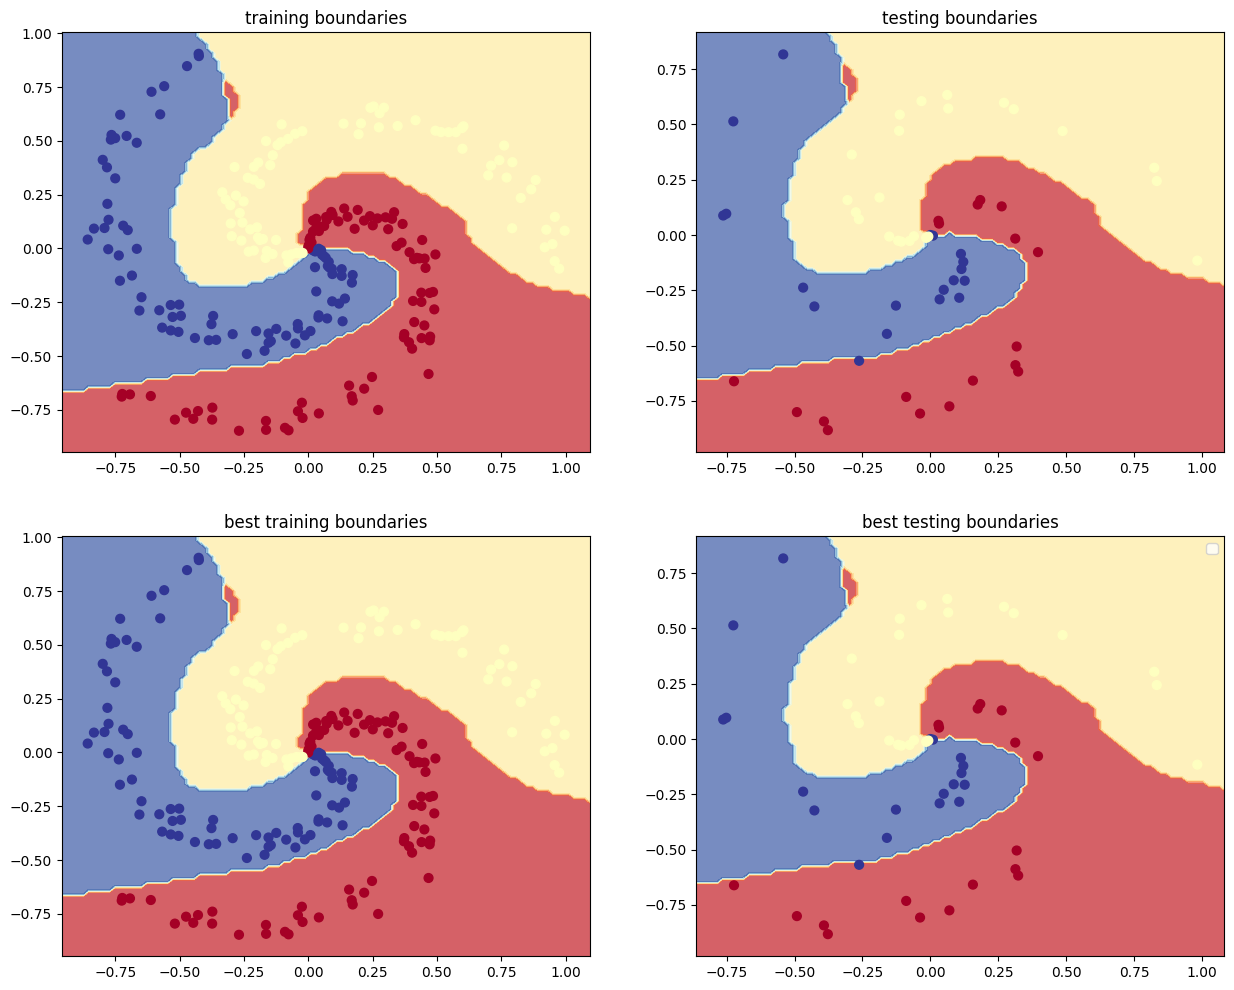

In [363]:
plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
hf.plot_decision_boundary(model,X_train,y_train)
plt.title("training boundaries")
plt.subplot(2,2,2)
hf.plot_decision_boundary(model,X_test,y_test)
plt.title("testing boundaries")
plt.subplot(2,2,3)
hf.plot_decision_boundary(best_model,X_train,y_train)
plt.title("best training boundaries")
plt.subplot(2,2,4)
hf.plot_decision_boundary(best_model,X_test,y_test)
plt.title("best testing boundaries")
plt.legend()